2019-01-01T00:00:00.000000Z


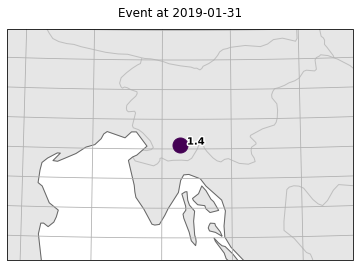

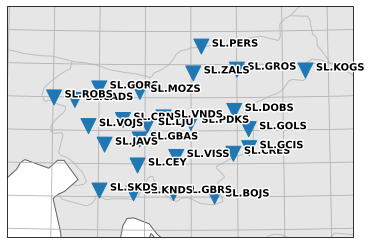

In [6]:
from obspy import UTCDateTime, Stream
import cartopy
import matplotlib.pyplot as plt
from obspy.clients.fdsn import Client, RoutingClient
import os

def mpl_plot(stream, figsize=[12.0, 8.0], linewidth=1):
    '''
    This function is used for plotting of the seismograms.
    It is not needed, since the obspy already has this functionality,
    but since we will be adding some elements to the plot, it makes it more convinient.
    '''
    if len(stream)==1:
        fig, ax = plt.subplots(nrows=len(stream), ncols=1, figsize=figsize)
        ax.plot(stream[0].times("matplotlib"), stream[0].data, "k-",
                linewidth=linewidth, label=stream[0].stats.station+'.'+stream[0].stats.channel)
        ax.legend(loc=2)
    else:
        fig, ax = plt.subplots(nrows=len(stream), ncols=1, figsize=figsize)
        for i, tr in zip(range(0,len(stream)), stream):
            ax[i].plot(tr.times("matplotlib"), tr.data, "k-",
                       linewidth=linewidth, label=tr.stats.station+'.'+tr.stats.channel)
            ax[i].legend(loc=2)

starttime_cat = UTCDateTime(2019, 1, 1, 0, 0, 0)
endtime_cat = UTCDateTime(2019, 2, 1, 0, 0, 0)

# This time we will use a different provider (before it was ISC).
client = Client("IRIS") # client of inventory/waveform
# level='response' will get us the info needed for removal of instrumental response.
inv = client.get_stations(network='SL', station="*", level='response',
                                starttime=starttime_cat, endtime=endtime_cat)
client = Client("ISC") # client of earthquake catalog

# Define the start time and end time of the catalog


print(starttime_cat)

# Define the area of interest. Check obspy manual for other settings.
minlatitude, maxlatitude   = 45.35, 46.94
minlongitude, maxlongitude = 13.28, 16.72

# Execute the get_events call to obtain predefined catalog
cat = client.get_events(starttime=starttime_cat, 
                        endtime=endtime_cat, 
                        minlongitude=minlongitude, 
                        maxlongitude=maxlongitude, 
                        minlatitude=minlatitude, 
                        maxlatitude=maxlatitude)

# Select the events and plot
events = cat.filter("time > 2019-01-31T23:35:0", "time < 2019-01-31T23:40:0")
fig = events.plot('local', 'i', method='cartopy')
fig.savefig("events.pdf")


# Plot inventory
fig = inv.plot('local', 'i', method='cartopy', color='tab:blue')
fig.savefig('stations.pdf')



In [7]:

# From the map, specify stations
stations = ['CEY', 'GBAS', 'JAVS', 'KNDS', 'SKDS', 'VOJS']
# This is another version of client. For more, check Obspy manual.
rsClient = RoutingClient("eida-routing")

# Lets download only 5 minutes around the event.
starttime = UTCDateTime(2019, 1, 31, 23, 35, 0)
endtime = UTCDateTime(2019, 1, 31, 23, 40, 0)

# We generate an empty stream object into witch we will add our downloaded data.
st = Stream()
for sta in stations:
    stream = rsClient.get_waveforms(network='SL', station=sta, channel="HH*",
                                    starttime=starttime, endtime=endtime)
    stream.merge(fill_value=0)
    stream.detrend('simple')
    stream.detrend('demean')
    for tr in stream:
        st+=tr